In [121]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import pandas as pd
import numpy as np
import random

In [3]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)  

In [4]:
dataset = pd.read_csv('19JuneDataset.csv')
dataset.head()

,time,A0,A1,A2,A5,A6,A7,X,Y,Z
0,0.000000,3.02,1.87,0.28,2.45,0.14,0.0,-0.629333,0.844733,1.169218
1,0.046863,2.95,1.80,0.00,1.87,0.00,0.0,-0.629225,0.844531,1.169302
2,0.078058,2.95,1.80,0.07,2.16,0.00,0.0,-0.629148,0.844372,1.169372
3,0.109227,3.02,1.65,0.00,2.01,0.00,0.0,-0.629085,0.844232,1.169426
4,0.140454,3.17,1.80,0.07,2.30,0.07,0.0,-0.629038,0.844166,1.169454


In [5]:
X, y = dataset[["X", "Y", "Z"]], dataset[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

x_mean = X.iloc[:, 0].mean()

x_std = X.iloc[:, 0].std()
y_mean = X.iloc[:, 1].mean()
y_std = X.iloc[:, 1].std()
z_mean = X.iloc[:, 2].mean()
z_std = X.iloc[:, 2].std()

# Normalize each column
X_norm = np.copy(X)
X_norm[:, 0] = (X.iloc[:, 0] - x_mean) / x_std
X_norm[:, 1] = (X.iloc[:, 1] - y_mean) / y_std
X_norm[:, 2] = (X.iloc[:, 2] - z_mean) / z_std

y_norm = y / 73.8

In [6]:
X_norm = torch.tensor(pd.DataFrame(X_norm).values, dtype=torch.float32)
y_norm = torch.tensor(pd.DataFrame(y_norm).values, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
class LinearlyActuatedStrutsHe(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsHe, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
        # Initialize weights with Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42) # Set seed for reproducibility
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)
    

rf_model = RandomForestRegressor(max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150, random_state=42)
rf_model.fit(X_train.numpy(), y_train.numpy())

RandomForestRegressor(max_features=None, min_samples_split=10, n_estimators=150,
                      random_state=42)

In [32]:
def evaluate_nn(X_test):
    model = LinearlyActuatedStrutsHe()
    model.load_state_dict(torch.load(f'models/best_He_Model_1e-3.pth'))
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)

    predictions = torch.round(predictions, decimals=2)  # Round to 2 decimal places
    return predictions * 73.8  # Scale back to original range


def evaluate_rf(X_test):
    predictions = rf_model.predict(X_test.numpy())
    predictions = torch.tensor(predictions, dtype=torch.float32) * 73.8
    predictions = torch.round(predictions, decimals=2)  # Round to 2 decimal places
    return predictions # Scale back to original range


In [33]:
X_test = [-0.629333, 0.844733, 1.169218]   
X_test_norm = [(X_test[0] - x_mean) / x_std, (X_test[1] - y_mean) / y_std, (X_test[2] - z_mean) / z_std]
X_test_norm = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
print("Normalized Test Input:", X_test_norm)
evaluate = evaluate_rf(X_test_norm)
print(evaluate)

Normalized Test Input: tensor([[ 0.0685,  0.3979, -4.3411]])
tensor([[7.5200, 4.8000, 0.0300, 4.0800, 2.6800, 2.7300]])


In [34]:
def normalize_input(input_data):
    """Normalize input data using pre-computed means and stds."""
    normalized_data = np.copy(input_data)
    normalized_data[:, 0] = (input_data[:, 0] - x_mean) / x_std
    normalized_data[:, 1] = (input_data[:, 1] - y_mean) / y_std
    normalized_data[:, 2] = (input_data[:, 2] - z_mean) / z_std
    return torch.tensor(normalized_data, dtype=torch.float32)  

normalize_input()

In [38]:
# First target

first_nn = evaluate_nn(normalize_input(np.array([-0.6109, 0.82, 1.2496]).reshape(1, -1)))
print("First NN Prediction:", first_nn)

First NN Prediction: tensor([[73.8000, 73.8000, 73.8000,  1.4760, 28.0440, 39.8520]])


In [39]:
# Second target

second_nn = evaluate_nn(normalize_input(np.array([-0.639, 0.8661, 1.23]).reshape(1, -1)))
print("Second NN Prediction:", second_nn)

Second NN Prediction: tensor([[39.8520, 53.1360, 38.3760, 36.1620,  0.7380, 38.3760]])


In [45]:
# Third target

third_nn = evaluate_nn(normalize_input(np.array([-0.6434, 0.8378, 1.218]).reshape(1, -1)))
print("Third NN Prediction:", third_nn)

Third NN Prediction: tensor([[65.6820, 51.6600,  0.7380, 25.0920, 23.6160, 20.6640]])


In [41]:
# Fourth target
fourth_nn = evaluate_nn(normalize_input(np.array([-0.6398, 0.855, 1.247]).reshape(1, -1)))
print("Fourth NN Prediction:", fourth_nn)

Fourth NN Prediction: tensor([[52.3980, 59.0400, 50.9220, 47.9700,  0.0000, 58.3020]])


In [50]:
# Multiple targets

multiple_nn = evaluate_nn(normalize_input(np.array([[-0.640218, 0.8418, 1.21258], [-0.630, 0.845, 1.247], [-0.617, 0.878, 1.27]])))
print("Multiple NN Predictions:")
print(multiple_nn)

Multiple NN Predictions:
tensor([[57.5640, 40.5900,  0.0000, 20.6640, 25.0920, 27.3060],
        [57.5640, 62.7300, 61.9920, 52.3980,  0.0000, 60.5160],
        [ 9.5940, 73.8000, 18.4500, 73.8000, 73.8000, 73.8000]])


# Multiple targets NN 2

multiple_nn_2 = evaluate_nn(normalize_input(np.array([[-0.625, 0.845, 1.212],
    [-0.624, 0.846, 1.241],
    [-0.607, 0.849, 1.264]])))

print("Multiple NN 2 Predictions:")
print(multiple_nn_2)

Evaluating Random Forest

In [42]:
# First target RF
first_rf = evaluate_rf(normalize_input(np.array([-0.6109, 0.82, 1.2496]).reshape(1, -1)))
print("First RF Prediction:", first_rf)

First RF Prediction: tensor([[60.9000, 24.6700, 51.4800, 55.8700, 68.9000, 72.4100]])


In [44]:
# Second target RF
second_rf = evaluate_rf(normalize_input(np.array([-0.639, 0.8661, 1.23]).reshape(1, -1)))
print("Second RF Prediction:", second_rf)

Second RF Prediction: tensor([[44.3300, 50.5600, 45.8200, 49.0900,  0.0000, 45.0800]])


In [47]:
# Third target RF
third_rf = evaluate_rf(normalize_input(np.array([-0.6434, 0.8378, 1.218]).reshape(1, -1)))
print("Third RF Prediction:", third_rf)

Third RF Prediction: tensor([[66.2600, 65.4400, 61.9400, 30.2800,  2.1800,  5.3500]])


In [48]:
# Fourth target RF
fourth_rf = evaluate_rf(normalize_input(np.array([-0.6398, 0.855, 1.247]).reshape(1, -1)))
print("Fourth RF Prediction:", fourth_rf)

Fourth RF Prediction: tensor([[57.8700, 61.4100, 58.9400, 55.3700,  0.0000, 58.5800]])


In [51]:
# Multiple targets

multiple_rf = evaluate_rf(normalize_input(np.array([[-0.640218, 0.8418, 1.21258], [-0.630, 0.845, 1.247], [-0.617, 0.878, 1.27]])))
print("Multiple NN Predictions:")
print(multiple_rf)

Multiple NN Predictions:
tensor([[28.0200, 26.5900, 11.1800, 22.1800,  8.1200, 20.6400],
        [57.4100, 61.0300, 58.4900, 54.8100,  0.0000, 54.0400],
        [17.5100, 57.1300, 15.1500, 73.4800, 73.5500, 73.7100]])


Results from evaluation on Physical Setup

In [81]:
ground_truth = [
    [-0.6109, 0.82, 1.2496],
    [-0.639, 0.8661, 1.23],
    [-0.6434, 0.8378, 1.218],
    [-0.6398, 0.855, 1.247]
]

nn_predictions = [
    [-0.6084, 0.82, 1.238],
    [-0.6329, 0.848638, 1.21839],
    [-0.63127, 0.84688, 1.2169],
    [-0.63226, 0.846841, 1.2353]
]

rf_predictions = [
    [-0.6177, 0.7778, 1.25322],
    [-0.62927, 0.839661, 1.226681],
    [-0.631685, 0.832213, 1.222767],
    [-0.632756, 0.839388, 1.23996]
]

ground_truth_multiple = [
    [-0.640218, 0.8418, 1.21258],
    [-0.630, 0.845, 1.247],
    [-0.617, 0.878, 1.27]
]

nn_predictions_multiple = [
    [-0.663, 0.847, 1.213],
    [-0.63, 0.842, 1.242],
    [-0.617, 0.859, 1.259]
]

rf_predictions_multiple = [
    [-0.637, 0.840, 1.199],
    [-0.634, 0.839, 1.239],
    [-0.625, 0.842, 1.257]
]

ground_truth_multiple_2 = [
    [-0.625, 0.845, 1.212],
    [-0.624, 0.846, 1.241],
    [-0.607, 0.849, 1.264]
]

nn_predictions_multiple_2 = [
    [-0.648, 0.841, 1.212],
    [-0.625, 0.842, 1.24],
    [-0.601, 0.837, 1.263]
]

In [59]:
# Calculating Euclidean distances

def euclidean_distance(predictions, ground_truth):
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    return np.linalg.norm(predictions - ground_truth, axis=1)

nn_distances = euclidean_distance(nn_predictions, ground_truth)
rf_distances = euclidean_distance(rf_predictions, ground_truth)

nn_distances_multiple = euclidean_distance(nn_predictions_multiple, ground_truth_multiple)
rf_distances_multiple = euclidean_distance(rf_predictions_multiple, ground_truth_multiple)

concat_nn = np.concatenate((nn_distances, nn_distances_multiple))
concat_rf = np.concatenate((rf_distances, rf_distances_multiple))

print("Average Euclidean Distance for NN:", np.mean(concat_nn), " meters")
print("Average Euclidean Distance for RF:", np.mean(concat_rf), " meters")


Average Euclidean Distance for NN: 0.01659829921160355  meters
Average Euclidean Distance for RF: 0.02393627553232513  meters


Plotting results for NN

In [226]:
# Plotting the results for NN model

home_position = [-0.62239, 0.84516, 1.1729]

def format_sigfig(x, pos):
    return f"{x:.2g}"

def format_sigfig_z(x, pos):
    return f"{x:.2f}"

def plot_single_point_trajectories(home_pos, desired_point, actual_point, i, title="Trajectory Comparison"):
    """
    Plot 3D trajectories from home position to single desired and actual points
    
    Args:
        home_pos: [x, y, z] - home position
        desired_point: [x, y, z] - target destination
        actual_point: [x, y, z] - achieved position
        title: str - plot title
    """
    # Convert to numpy arrays
    home_pos = np.array(home_pos)
    desired_point = np.array(desired_point)
    actual_point = np.array(actual_point)
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot home position
    ax.scatter(*home_pos, c='g', s=100, label='Initial Position', marker='D')
    
    # Plot desired trajectory (home to desired point)
    desired_line = np.vstack([home_pos, desired_point])
    ax.plot(desired_line[:,0], desired_line[:,1], desired_line[:,2], 
            'b-', linewidth=2, label='Desired Trajectory')
    ax.scatter(*desired_point, c='b', s=80, label='Desired Position')
    
    # Plot actual trajectory (home to actual point)
    actual_line = np.vstack([home_pos, actual_point])
    ax.plot(actual_line[:,0], actual_line[:,1], actual_line[:,2], 
            'r--', linewidth=2, label='Actual Trajectory')
    ax.scatter(*actual_point, c='r', s=80, label='Actual Position')
    
    # Calculate error
    error = np.linalg.norm(desired_point - actual_point)
    
    # Add labels and title
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    # Remove default cropped label
    ax.set_zlabel('')

    # Add Z label manually
    ax.text2D(1.05, 0.5, 'Z (m)', transform=ax.transAxes, fontsize=14, rotation=90, va='center')
    ax.set_title(f"{title}\nPosition Error: {error:.4f} m", fontsize=16)

    ax.zaxis.label.set_rotation(90)

    # fig.subplots_adjust(left=0.04, right=0.05, bottom=0.05, top=0.95)

    ax.tick_params(labelsize=12)
    
    # Set equal aspect ratio
    all_points = np.vstack([home_pos, desired_point, actual_point])
    max_range = np.ptp(all_points, axis=0).max() / 2.0
    mid = np.mean(all_points, axis=0)
    xlim = (mid[0] - max_range, mid[0] + max_range)
    ylim = (mid[1] - max_range, mid[1] + max_range)
    zlim = (mid[2] - max_range, mid[2] + max_range)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    tick_spacing = 0.02
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[1:])    
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[1:])
    ax.set_xticks(np.arange(xlim[0], xlim[1] + tick_spacing, tick_spacing))
    ax.set_yticks(np.arange(ylim[0], ylim[1] + tick_spacing, tick_spacing))
    ax.set_zticks(np.arange(zlim[0], zlim[1] + tick_spacing, tick_spacing))

    ax.xaxis.set_major_formatter(FuncFormatter(format_sigfig))
    ax.yaxis.set_major_formatter(FuncFormatter(format_sigfig))
    ax.zaxis.set_major_formatter(FuncFormatter(format_sigfig_z))
    
    # Add legend and grid
    ax.legend(fontsize=12)
    ax.grid(True)
    ax.view_init(elev=15, azim=-55)
    ax.tick_params(labelsize=10)
    
    # Fix layout cropping by setting margins manually
    # plt.tight_layout(pad=3)  

    # fig.savefig(f"{i}trajectory_plot.png", bbox_inches='tight', dpi=300)

    return fig, ax

In [240]:
def plot_dual_trajectories(home_pos, ground_truth_multiple, nn_predictions_multiple, title="Trajectory Comparison"):
    """
    Plot two 3D trajectories (ground truth vs NN predictions) starting from home position
    
    Args:
        home_pos: [x, y, z] - starting position
        ground_truth_multiple: List of 3 XYZ points (excluding home) - ground truth trajectory
        nn_predictions_multiple: List of 3 XYZ points (excluding home) - predicted trajectory
        title: str - plot title
    """
    # Convert to numpy arrays and prepend home position
    home_pos = np.array(home_pos)
    gt_points = np.vstack([home_pos, ground_truth_multiple])
    nn_points = np.vstack([home_pos, nn_predictions_multiple])
    
    # Create figure
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot trajectories
    ax.plot(gt_points[:,0], gt_points[:,1], gt_points[:,2], 
            'b-o', linewidth=2, markersize=8, label='Ground Truth')
    ax.plot(nn_points[:,0], nn_points[:,1], nn_points[:,2], 
            'r--s', linewidth=2, markersize=8, label='NN Prediction')
    
    # Plot home position specially
    ax.scatter(*home_pos, c='g', s=150, marker='D', label='Initial Position')
    
    # Calculate and display errors
    errors = [np.linalg.norm(gt - nn) for gt, nn in zip(gt_points[1:], nn_points[1:])]
    error_text = "\n".join([f"Point {i+1} error: {err:.4f} m" for i, err in enumerate(errors)])
    ax.text2D(0.01, 0.98, error_text, transform=ax.transAxes, 
              bbox=dict(facecolor='white', alpha=0.8), fontsize=14)
    
    # Add labels and title
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    # Remove default cropped label
    ax.set_zlabel('')

    # Add Z label manually
    ax.text2D(1.05, 0.5, 'Z (m)', transform=ax.transAxes, fontsize=14, rotation=90, va='center')
    # ax.set_title(title, fontsize=16)
    ax.text2D(0.3, 0.9, title, transform=ax.transAxes, 
              bbox=dict(facecolor='white', alpha=0.8), fontsize=16)

    # Set equal aspect ratio
    all_points = np.vstack([gt_points, nn_points])
    max_range = np.ptp(all_points, axis=0).max() / 2.0
    mid = np.mean(all_points, axis=0)

    xlim = (mid[0] - max_range, mid[0] + max_range)
    ylim = (mid[1] - max_range, mid[1] + max_range)
    zlim = (mid[2] - max_range, mid[2] + max_range)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    tick_spacing = 0.02
    ax.set_xticks(np.arange(xlim[0], xlim[1] + tick_spacing, tick_spacing))
    ax.set_yticks(np.arange(ylim[0], ylim[1] + tick_spacing, tick_spacing))
    ax.set_zticks(np.arange(zlim[0], zlim[1] + tick_spacing, tick_spacing))

    ax.xaxis.set_major_formatter(FuncFormatter(format_sigfig))
    ax.yaxis.set_major_formatter(FuncFormatter(format_sigfig))
    ax.zaxis.set_major_formatter(FuncFormatter(format_sigfig_z))
    
    # Add legend and grid
    ax.legend(fontsize=12)
    ax.grid(True)
    ax.view_init(elev=15, azim=-55)
    
    # Fix layout cropping by setting margins manually
#     plt.tight_layout() 
    return fig, ax

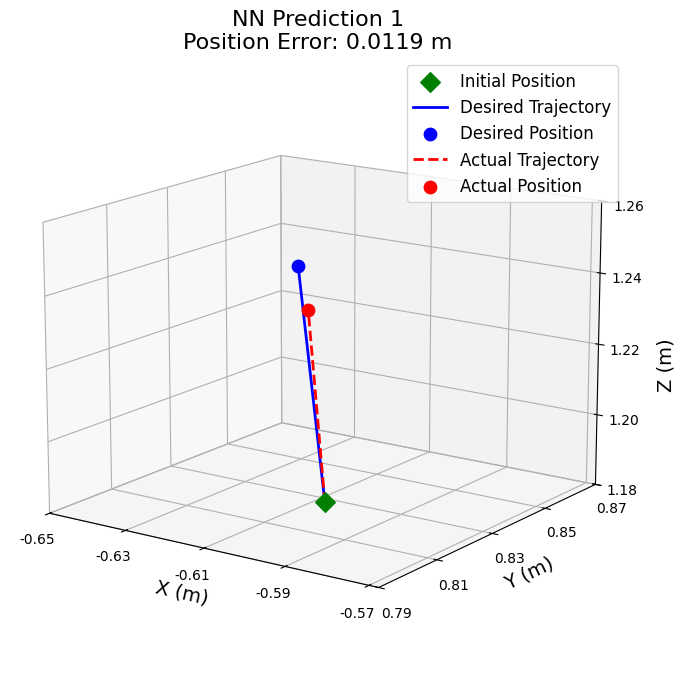

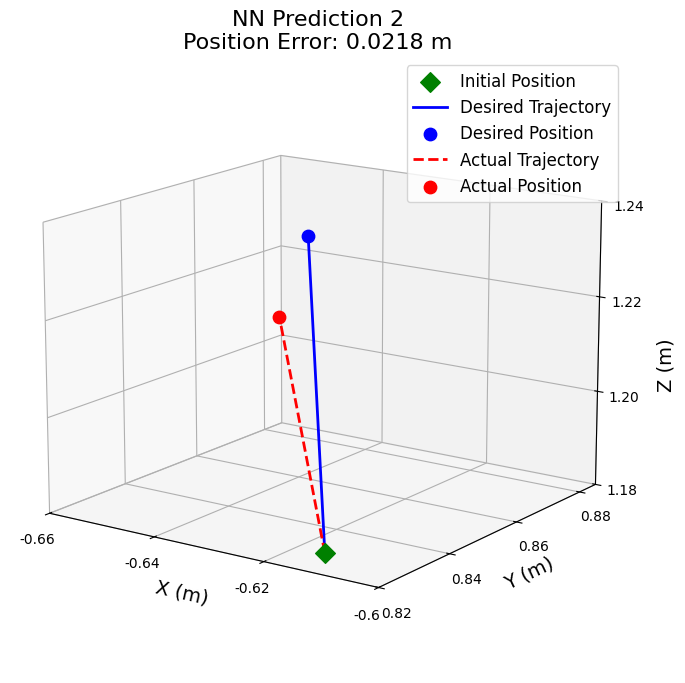

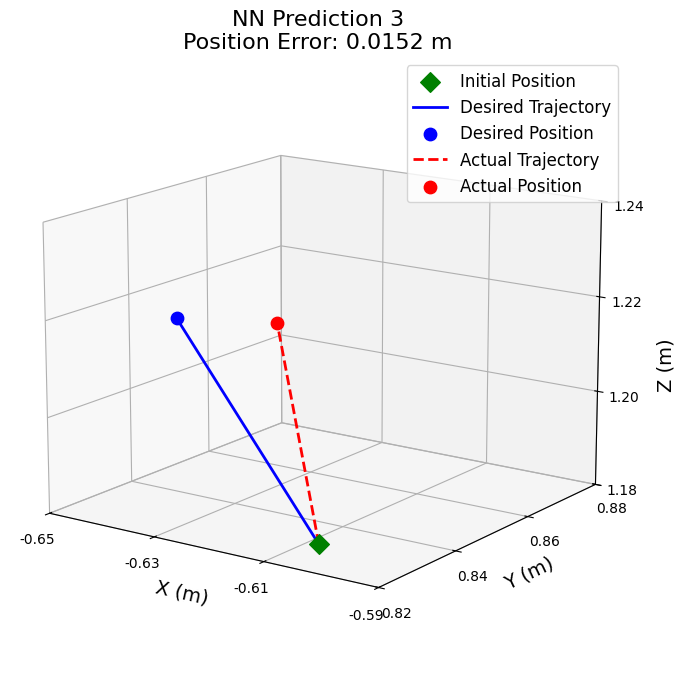

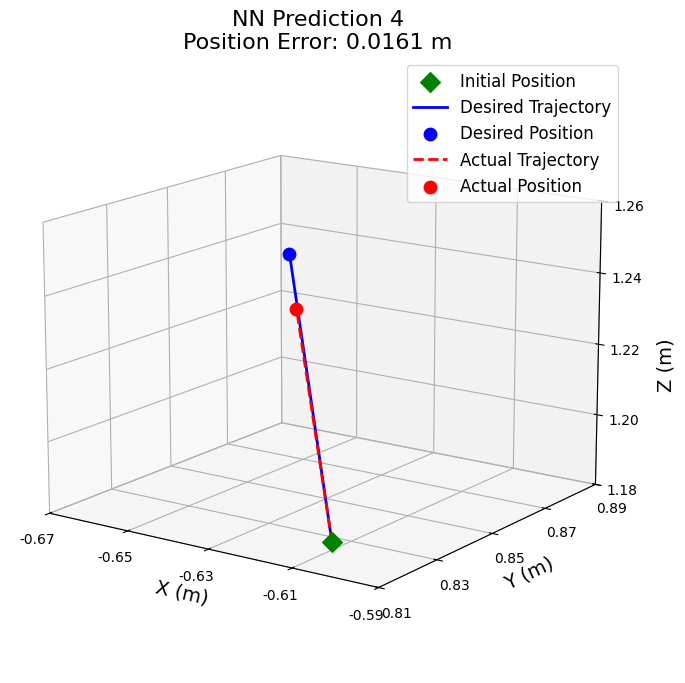

In [227]:
for i in range(len(ground_truth)):
    fig, ax = plot_single_point_trajectories(home_position, ground_truth[i], nn_predictions[i], title=f"NN Prediction {i+1}", i=i+1)
    plt.show()

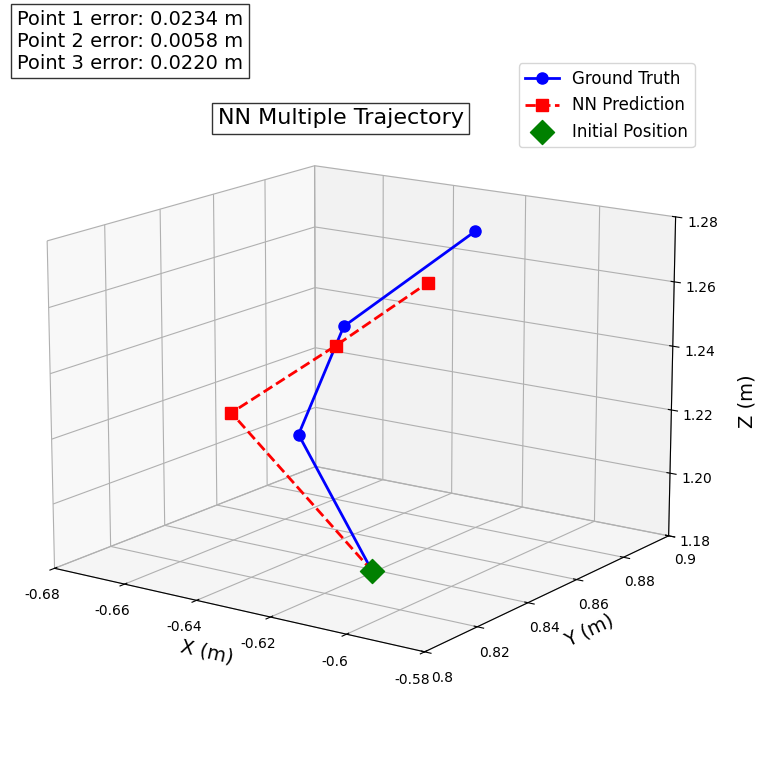

In [241]:
fig, ax = plot_dual_trajectories(home_position, ground_truth_multiple, nn_predictions_multiple, title="NN Multiple Trajectory")

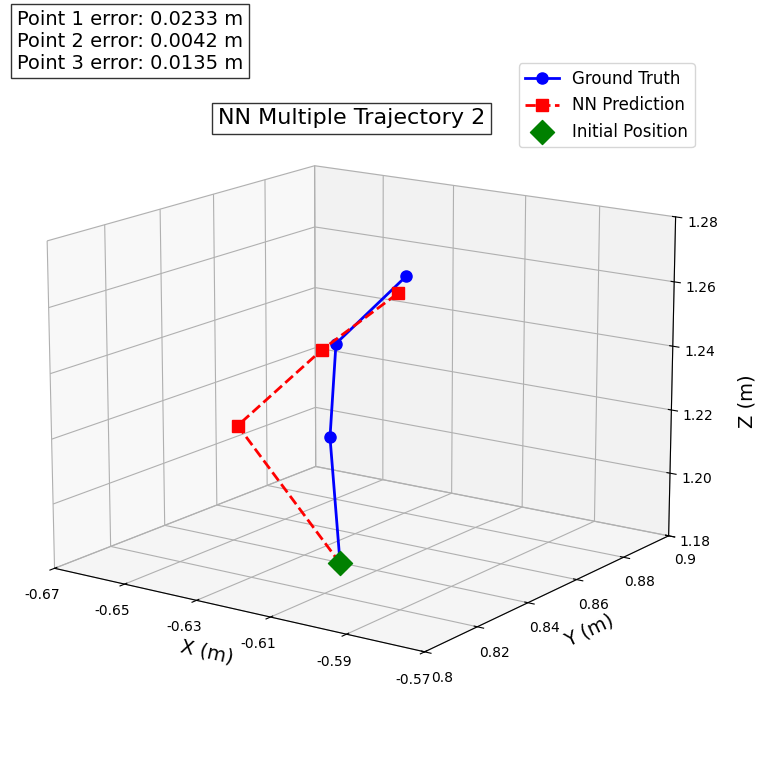

In [242]:
fig, ax = plot_dual_trajectories(home_position, ground_truth_multiple_2, nn_predictions_multiple_2, title="NN Multiple Trajectory 2")